<img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="240" height="360" />

# TIME SERIES ANALYSIS

![Imgur](https://i.imgur.com/aooy8xP.gif)

## Table of contents
1. [Objective](#Objective)
2. [Data Loading and Visualization](#Data Loading and Visualization)
3. [Decomposition](#Decomposition)
4. [Stationarity Check](#Stationarity Check)<br/>
    4.1. [Rolling Statistics Methodology](#Rolling Statistics Methodology)<br/>
    4.2. [ADF(Augmented Dickey-Fuller)Test](#ADF)   
5. [Data Transformation to achieve Stationarity](#Data Transformation to achieve Stationarity)<br/>
    5.1. [Log Scale Transformation](#Log Scale Transformation)<br/>
    5.2. [Log Scale - Moving Average Transformation](#Log Scale - Moving Average Transformation)<br/>
    5.3. [Exponential Decay Transformation](#Exponential Decay Transformation)<br/>
    5.4. [Time Shift Transformation](#Time Shift Transformation)<br/>
6. [Plotting ACF & PACF](#Plotting ACF & PACF)
7. [Building Models](#Building Models)<br/>
    7.1. [AR Model](#AR Model)<br/>
    7.2. [ARMA Model](#ARMA Model)<br/>
    7.3. [ARIMA Model](#ARIMA Model)<br/>
8. [Extra Material ](#Extra Material )


### 1. Objective <a name = "Objective"></a>
- Build a model to forecast the demand ( passenger traffic) in Airplanes.
- The data is classified in date/time and the passengers travelling per month

### 2. Data Loading and Visualization <a name = "Data Loading and Visualization"></a>

__Import the dataset__ 

In [1]:
import pandas as pd  
dataset  =  pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Data/CaseStudy/AirPassengers.csv')
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Time series deals with 2 columns,
- one is temporal i.e: __month__ in this case &
- another is the value to be forecasted ie: __airplane passengers__. <br/>


To make plotting graphs easier, we set __Month as the index__ of pandas dataframe as during plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis.

In [2]:
from datetime import datetime

dataset['Month']  =  pd.to_datetime(dataset['Month'],infer_datetime_format = True )             #convert from string to datetime

indexedDataset  =  dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


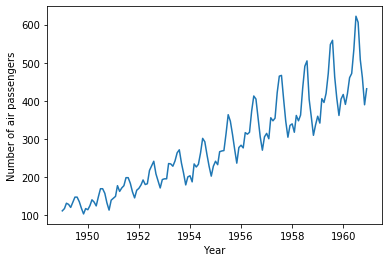

In [3]:
import matplotlib.pylab as plt 
%matplotlib inline                        

plt.xlabel('Year')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

From the plot below, we can see that there is a __Trend compoenent__ in the series.<br/> Now for better clarity lets decompose the time series in its constituent components. 

### 3. Decomposition <a name = "Decomposition"></a>

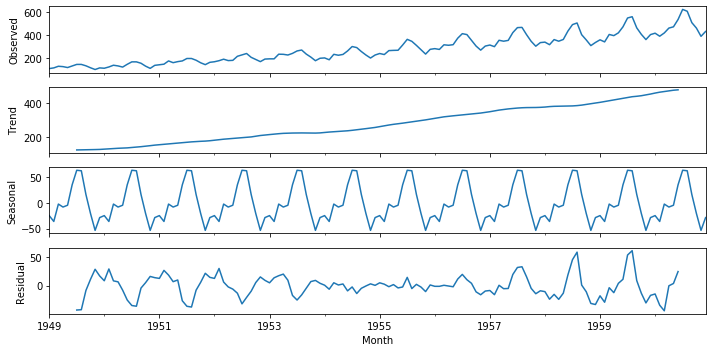

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']  =  10, 5

from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_dataset  =  seasonal_decompose(indexedDataset)         
figure  =  decomposed_dataset.plot()
plt.show()

### 4. Stationarity Check <a name = "Stationarity Check"></a>

We will see two methods two check stationarity. 

![Imgur](https://i.imgur.com/TOsgav1.jpg)

Making a function to check stationarity in one go using both __rolling statistics plot and ADF test__.

#### 4.1 Rolling Statistics Methodology <a name = "Rolling Statistics Methodology"></a>

In [5]:
# Determine rolling statistics
def rolling_stat(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    #Plot rolling statistics
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize']  =  10, 5 

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

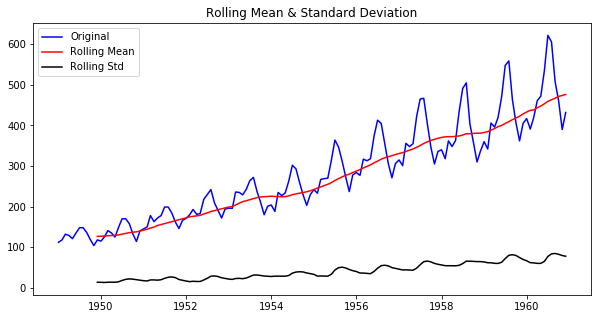

In [6]:
rolling_stat(indexedDataset)

- Rolling mean has a __trend__ component 
- Rolling standard deviation is fairly __constant__ with time.

For our time series to be stationary, we need to ensure that both the __rolling statistics__ i.e: __mean & stdandard deviation remain time invariant__ or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so. 

To further augment our hypothesis that the time series is not stationary, let us perform the __ADCF test__.

#### 4.2  ADF(Augmented Dickey-Fuller) Test <a name = "ADF"></a>

For a Time series to be __stationary__, its ADF test should have:
1. __low p-value__ (according to the null hypothesis)
2. __Critical values__ at 1%, 5%, 10% confidence intervals should be as __close__ as possible __to__ the __Test Statistics__

In [7]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series['#Passengers'], autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:')    
    print(dfoutput)

In [8]:
adf_test(indexedDataset)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


- __large p-value__.
- Also critical values (1%, 5%, 10%) are __no where close to__ the Test Statistics.

Hence, we can safely say that **our Time Series at the moment is not stationary**

In [9]:
def test_stationarity(time_series):
    rolling_stat(time_series)
    adf_test(time_series)

### 5. Data Transformation to achieve Stationarity <a name = "Data Transformation to achieve Stationarity"></a>

There are a couple of ways to achieve stationarity through data transformation like taking $log_{10}$,$log_{e}$, square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. 

#### 5.1 Log Scale Transformation  <a name = "Log Scale Transformation"></a>

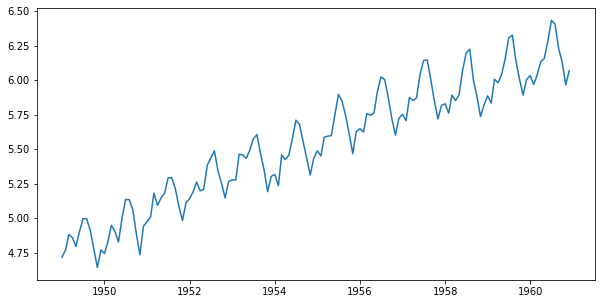

In [10]:
import numpy as np
indexedDataset_logScale  =  np.log(indexedDataset)
rcParams['figure.figsize']  =  10, 5
plt.plot(indexedDataset_logScale)

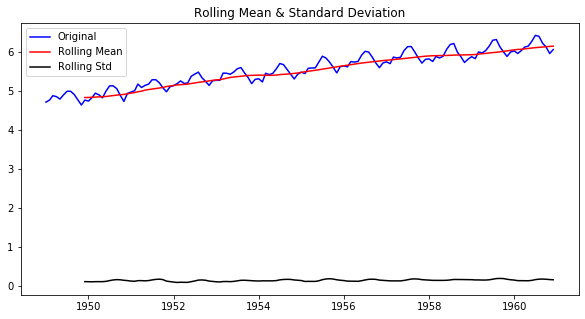

Results of Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [11]:
test_stationarity(indexedDataset_logScale)

Still not stationary

From above graph, we see that even though rolling mean is __not stationary__, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:  

$log scale L  =  stationary part(L1) + trend(LT)$   
$moving avg of log scale A  =  stationary part(A1) + trend(AT)$   
$result series R  =  L - A  =  (L1+LT) - (A1+AT)  =  (L1-A1) + (LT-AT)$

Since, L & A are series & it moving avg, their trend will be more or less same, Hence  
LT-AT nearly equals to 0  

Thus trend component will be almost removed. And we have,  
  
$R  =  L1 - A1$, our final non-trend curve

#### 5.2 Log Scale - Moving Average Transformation  <a name = "Log Scale - Moving Average Transformation"></a>

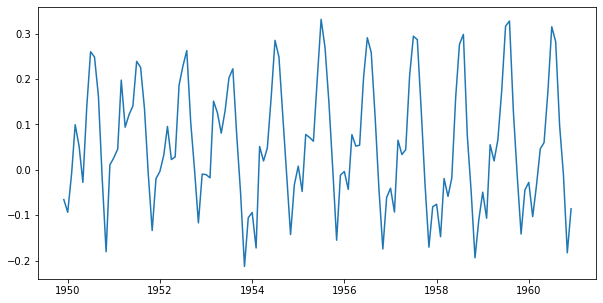

In [12]:
movingAverage  =  indexedDataset_logScale.rolling(window = 12).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset_logScale - movingAverage
plt.plot(datasetLogScaleMinusMovingAverage)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)


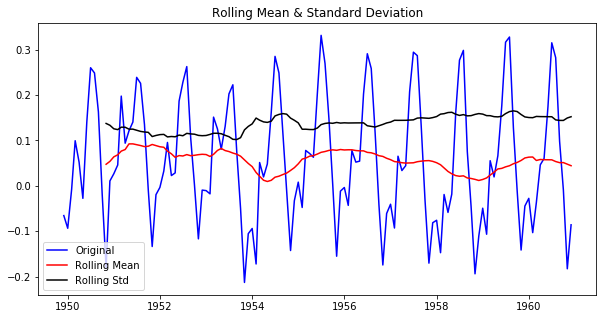

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
test_stationarity(datasetLogScaleMinusMovingAverage)

- p-value has __reduced__ from 0.99 to 0.022.  
- The __critical values__ at 1%,5%,10% confidence intervals are pretty __close to the Test Statistic__.

Thus, from above 2 points, we can say that our given series is stationary.  

From above graph, we observe that our intuition that *"subtracting two related series having similar trend components will make the result stationary"* is true.   



But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.  

### 5.3 Exponential Decay Transformation   <a name = "Exponential Decay Transformation "></a>

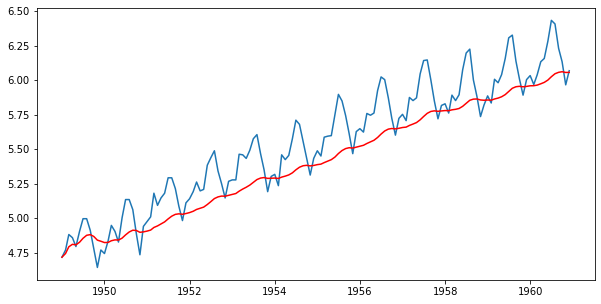

In [20]:
exponentialDecayWeightedAverage  =  indexedDataset_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

#tsa - transformations available

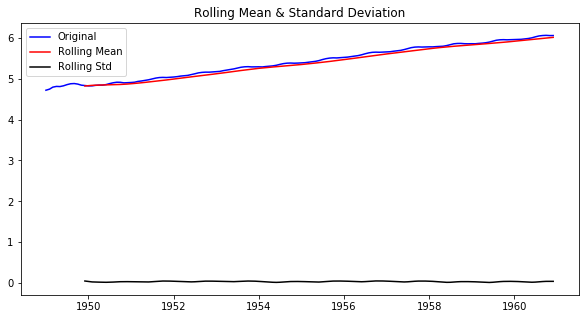

Results of Dickey Fuller Test:
Test Statistic                  -2.148248
p-value                          0.225561
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [21]:
test_stationarity(exponentialDecayWeightedAverage)

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar.

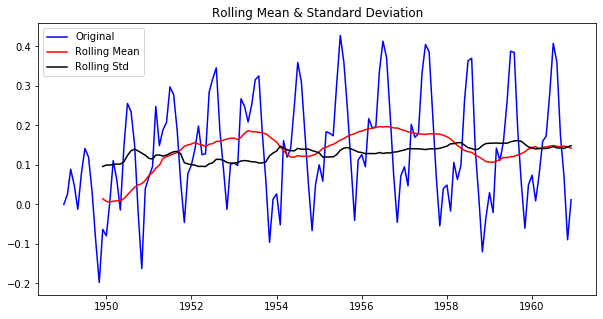

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
datasetLogScaleMinusExponentialMovingAverage  =  indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.  
Also,     
1. p-value has __decreased__ from 0.022 to 0.005.  
2. Test Statistic value is very __much closer__ to the Critical values.  


Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.

But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:  

Given a set of observation on the time series:  
$ x0, x1, x2, x3, .... xn $  

The shifted values will be:    
$ null, x0, x1, x2,.... xn $                             <---- basically all xi's shifted by 1 pos to right  

Thus, the time series with time shifted values are:   
$ null, (x1-x0), (x2-x1), (x3-x2), (x4-x3),.... (xn-x_{n-1}) $   

### 5.4 Time Shift Transformation  <a name = "Time Shift Transformation"></a>

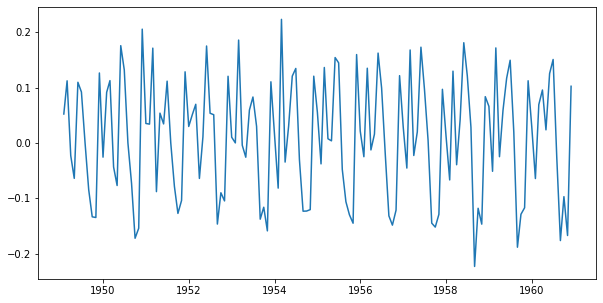

In [23]:
datasetLogDiffShifting  =  indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

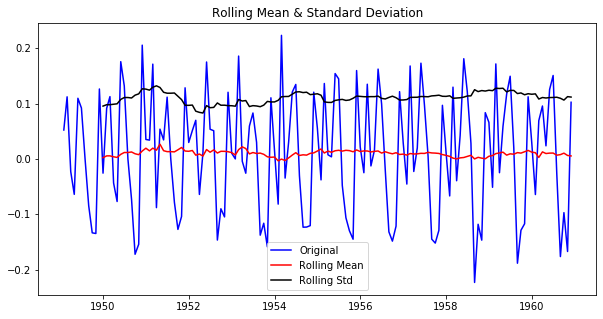

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [24]:
datasetLogDiffShifting.dropna(inplace = True)

test_stationarity(datasetLogDiffShifting)


From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:
1. p-value of 0.07 is not as good as 0.005 of exponential decay.  
2. Test Statistic value not as close to the critical values as that for exponential decay.  
  
We have thus tried out 3 different transformation: log, exp decay & time shift. We will go ahead with the __timeshifted dataset.__ 

### 6. Plotting ACF & PACF <a name = "Plotting ACF & PACF"></a>

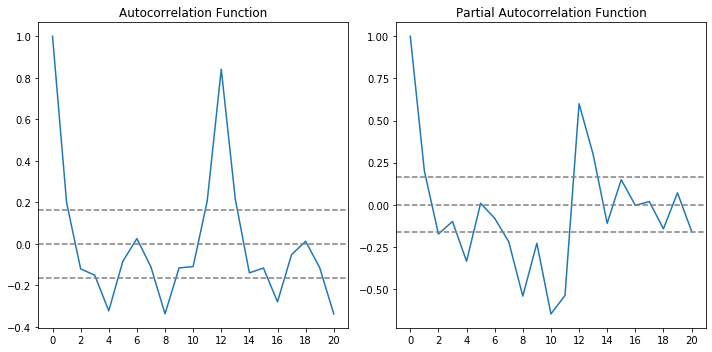

In [25]:
#ACF & PACF plots

from statsmodels.tsa.stattools import acf, pacf

lag_acf  =  acf(datasetLogDiffShifting, nlags = 20)
lag_pacf  =  pacf(datasetLogDiffShifting, nlags = 20, method = 'ols')


rcParams['figure.figsize']  =  10, 5
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,2))
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,2))
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the __ACF graph__, 
- Curve touches y = 0.0 line at x = 2. Thus, __Q  =  2__


From the __PACF graph__,
- Curve touches y = 0.0 line at x = 2. Thus, __P  =  2__

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

### 7. Building Models <a name = "Building Models"></a>

Let us forecaste deploying AR, ARMA and ARIMA model.

#### 7.1 AR Model <a name = "AR Model"></a>

- Using AR model to forecast the number of passengers for __7 months__. 
- Dividing the dataset into __train and test__. Keeping last 7 months data for testing the performance of our time series model.

In [26]:
datasetLogDiffShifting.head()

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [27]:
# Data Preparation
train, test = datasetLogDiffShifting[1:len(datasetLogDiffShifting)-7], datasetLogDiffShifting[len(datasetLogDiffShifting)-7:]
train.head()

,#Passengers
Month,
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
1949-07-01,0.091937


- Deploying the autoregression model of __statsmodels library__ provided in the ar_model class.
- It automatically selects an appropriate lag value using statistical tests and trains a linear regression model.

In [28]:
from statsmodels.tsa.ar_model import AR
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 13
Coefficients: const              0.024132
L1.#Passengers    -0.388718
L2.#Passengers    -0.245065
L3.#Passengers    -0.161839
L4.#Passengers    -0.244924
L5.#Passengers    -0.110113
L6.#Passengers    -0.221159
L7.#Passengers    -0.175594
L8.#Passengers    -0.279206
L9.#Passengers    -0.121380
L10.#Passengers   -0.238488
L11.#Passengers   -0.109462
L12.#Passengers    0.666398
L13.#Passengers    0.305571
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


- Observe that a __13-lag model__ was chosen and trained. This is interesting given how close this lag is to the number of months in a year.

- __Forecasting__ using the developed model and printing out the __7 month forecast__.

In [29]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
predictions.head()
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test.iloc[i]))


predicted=0.122213, expected=0.125288
predicted=0.145651, expected=0.150673
predicted=0.004964, expected=-0.026060
predicted=-0.152769, expected=-0.176399
predicted=-0.150069, expected=-0.097083
predicted=-0.100238, expected=-0.167251
predicted=0.092260, expected=0.102279


- __Model evaluation__ using Mean_squared_error

Test MSE: 0.001


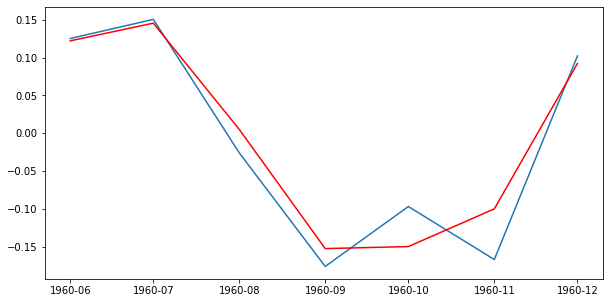

In [30]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Observing the plot of <span style="color:blue">**__expected__** </span> vs the <span style="color:red">**__predicted__** </span>.

The forecast does look pretty good with slightly large deviation on month 4.

Plotting AR model


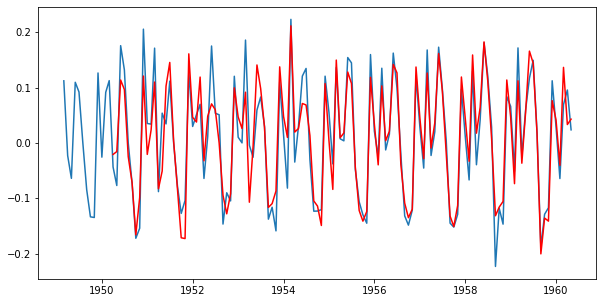

In [31]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting AR model')

#### 7.2 ARMA Model <a name = "ARMA Model"></a>

In [38]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train, order = (13,0))
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Lag: 13
Coefficients: const                 0.009973
ar.L1.#Passengers    -0.400374
ar.L2.#Passengers    -0.233506
ar.L3.#Passengers    -0.175919
ar.L4.#Passengers    -0.235958
ar.L5.#Passengers    -0.122683
ar.L6.#Passengers    -0.197276
ar.L7.#Passengers    -0.185144
ar.L8.#Passengers    -0.267659
ar.L9.#Passengers    -0.132106
ar.L10.#Passengers   -0.227580
ar.L11.#Passengers   -0.118494
ar.L12.#Passengers    0.659124
ar.L13.#Passengers    0.298715
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


- Observe that a __2-lag model__ was chosen and trained. 

- __Forecasting__ using the developed model and printing out the __7 month forecast__.

In [34]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
for i in range(len(predictions)):
    print('predicted=%f, actual=%f' % (predictions[i], test.iloc[i]))

predicted=0.012262, actual=0.125288
predicted=0.027899, actual=0.150673
predicted=0.013785, actual=-0.026060
predicted=0.015363, actual=-0.176399
predicted=0.011970, actual=-0.097083
predicted=0.011782, actual=-0.167251
predicted=0.010866, actual=0.102279


- __Model evaluation__ using Mean_squared_error

Test MSE: 0.017


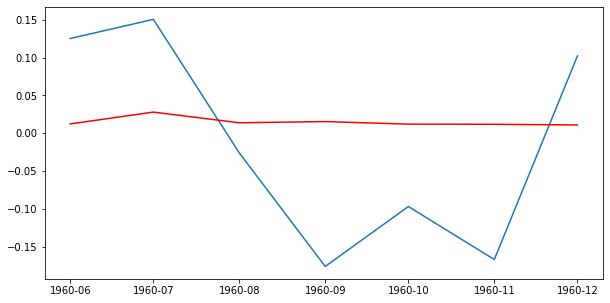

In [35]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

MSE is more than that obtained with AR model. <br/>
Observing the plot of <span style="color:blue">**__expected__** </span> vs the <span style="color:red">**__predicted__** </span>.
The forecast doesnt look good with large deviation at 3 and 5.

Plotting ARMA model


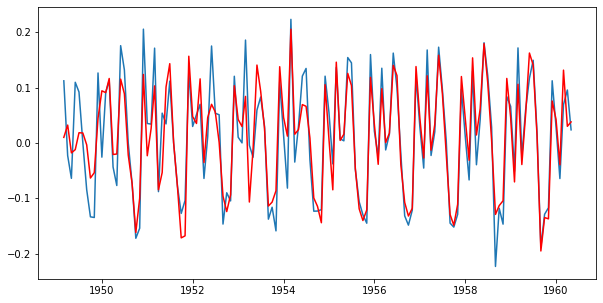

In [39]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting ARMA model')

- Alternatively you can also use __plot_predict()__ method. 

#### 7.3 ARIMA Model <a name = "ARIMA Model"></a>

- Training ARIMA model with __stationary__ made dataset "datasetLogDiffShifting" using the (p,d,q) = __(2,0,2)__. 
- p and q values are chosen considering observations of ACF and PACF plots.

In [48]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(datasetLogDiffShifting, order = (2,0,2))
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

#ARIMA(2,0,2) = ARMA (2,2)

Lag: 2
Coefficients: const                0.009580
ar.L1.#Passengers    1.629259
ar.L2.#Passengers   -0.894563
ma.L1.#Passengers   -1.827009
ma.L2.#Passengers    0.924471
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


- Observe that a __2-lag model__ was chosen and trained. 

- __Model evaluation__ using Mean_squared_error

In [49]:
results_ARIMA = model.fit()

In [51]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(datasetLogDiffShifting, results_ARIMA.fittedvalues)
print('Test MSE: %.3f' % error)

Test MSE: 0.007


In [52]:
results_ARIMA.fittedvalues.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

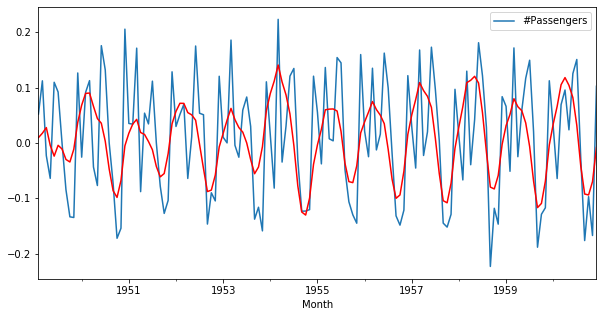

In [53]:
datasetLogDiffShifting.plot()
results_ARIMA.fittedvalues.plot(color='red')

- Alternatively you can also use __plot_predict()__ method. 

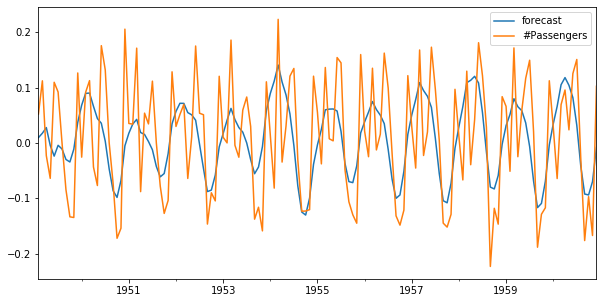

In [54]:
fitted_values = results_ARIMA.plot_predict()

### Prediction & Reverse transformations of fittedvalues 

In [55]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [60]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [61]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=datasetLogDiffShifting.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
1949-06-01    4.744830
dtype: float64

In [62]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

# all transforormation in reverse order.

,0
Month,
1949-02-01,113.078121
1949-03-01,115.073414
1949-04-01,118.301988
1949-05-01,117.768365
1949-06-01,114.988273


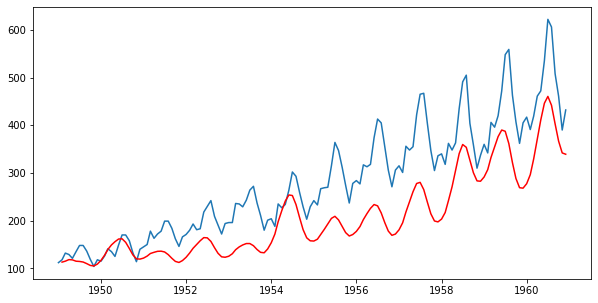

In [63]:
from matplotlib import pyplot
pyplot.plot(indexedDataset)
pyplot.plot(reverted_back_prediction, color='red')
pyplot.show()

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [64]:
indexedDataset_logScale.columns = ['Passengers in logscale']
reverted_back_prediction.columns = ['ARIMA Predicted passengers']
datasetLogDiffShifting.columns = ['Passengers after log diff shifting']

In [65]:
df = pd.concat([indexedDataset,indexedDataset_logScale, datasetLogDiffShifting,reverted_back_prediction], axis=1, sort=False)
df.tail()

,#Passengers,Passengers in logscale,Passengers after log diff shifting,ARIMA Predicted passengers
Month,,,,
1960-08-01,606,6.406880,-0.026060,441.884829
1960-09-01,508,6.230481,-0.176399,402.904449
1960-10-01,461,6.133398,-0.097083,366.752169
1960-11-01,390,5.966147,-0.167251,341.983559
1960-12-01,432,6.068426,0.102279,339.215567


### Forecasting the number of air passengers for the next 10 years

- We have 144(existing data of 12 yrs in months) data points. <br/>
To forecast additional 120 data points or __10 yrs__.
- Using plot_predict method

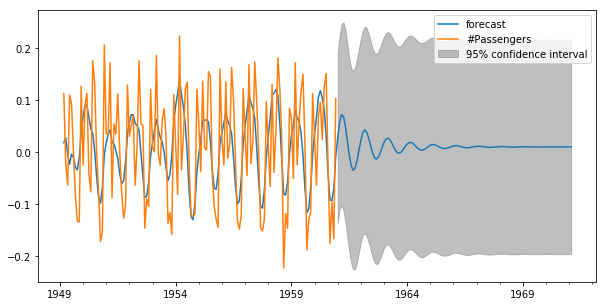

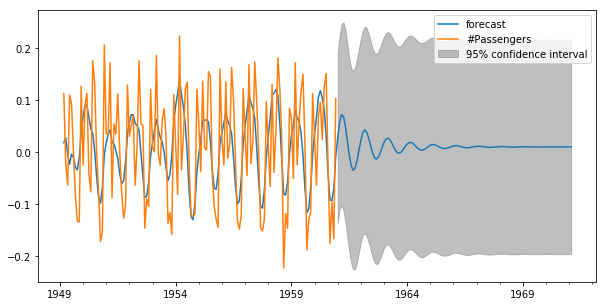

In [0]:
results_ARIMA.plot_predict(1,264) 

In [0]:
ten_yr_forecast = results_ARIMA.predict(start=len(datasetLogDiffShifting),end = len(datasetLogDiffShifting) + 120 ) 

### Prediction & Reverse transformations of 10 year forecast

In [0]:
predictions_ARIMA_diff = pd.Series(ten_yr_forecast, copy=True)
predictions_ARIMA_diff.head()

1961-01-01    0.027108
1961-02-01    0.057280
1961-03-01    0.071616
1961-04-01    0.067981
1961-05-01    0.049236
Freq: MS, dtype: float64

In [0]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

1961-01-01    0.027108
1961-02-01    0.084389
1961-03-01    0.156004
1961-04-01    0.223986
1961-05-01    0.273222
Freq: MS, dtype: float64

In [0]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers in logscale'].iloc[-1], index=predictions_ARIMA_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

1961-01-01    6.095534
1961-02-01    6.152814
1961-03-01    6.224430
1961-04-01    6.292411
1961-05-01    6.341647
Freq: MS, dtype: float64

In [0]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

,0
1961-01-01,443.871037
1961-02-01,470.038349
1961-03-01,504.935133
1961-04-01,540.454961
1961-05-01,567.730799


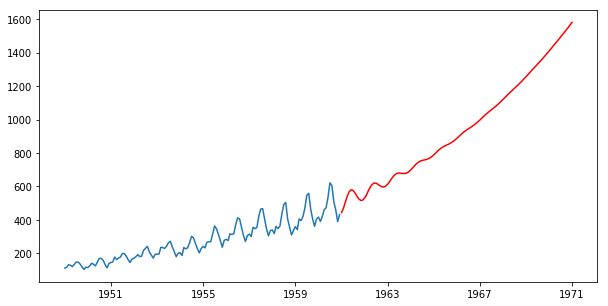

In [0]:
from matplotlib import pyplot
pyplot.plot(indexedDataset)
pyplot.plot(reverted_back_prediction, color='red')
pyplot.show()

### 8. Practice edits to the algo above  <a name = "Extra Material"></a>

 - Using ARIMA for making AR and MA models by setting the values of (p,d,q) as (2,1,0) and (0,1,2) respectively.

 - Using created AR(13) model and use that to predict.

 - use other smooting method and predict after that.

## The End